### In this project, we would explore regression analysis and make predictions on used car prices using an ensemble of regressors. After that, we would build a web app for user interactions and live predictions.
---
1. *In Part I of the project we pre-processed the data*
2. #### This is PART II of the project where we focus on regression methods and building an ensemble of them for used car prices prediction

#### Highlights of this part:
1.  Regression methods
2.  Building ensemble of regressors from scratch

**Citations:**

This dataset is from Kaggle - Used Cars Dataset

URL: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

---

The following description is from Kaggle:

**Context**

Craigslist is the world's largest collection of used vehicles for sale, yet it's very difficult to collect all of them in the same place. I built a scraper for a school project and expanded upon it later to create this dataset which includes every used vehicle entry within the United States on Craigslist.

**Content**

This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories. For ML projects, consider feature engineering on location columns such as long/lat. For previous listings, check older versions of the dataset.

See https://github.com/AustinReese1998/craigslistFilter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load dataset generated from Part I
df = pd.read_csv('Data/vehicles_pre-processed.csv')

#### Here we would draw a sample of 100000 from the dataframe to decrease the processing time. After model performance evaluations and improvements, we can retrain the model on the entire dataset.

In [3]:
df_original = df.copy()
df = df.sample(100000)
df.reset_index(drop = True, inplace = True)

In [4]:
df.head()

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state
0,22999,2013.0,ram,2500,diesel,209446.0,clean,automatic,co
1,4988,2005.0,subaru,forester,gas,105387.0,clean,automatic,id
2,9500,2010.0,toyota,Others,gas,95324.0,clean,automatic,in
3,6900,2010.0,subaru,forester,gas,189731.0,clean,manual,mi
4,3950,2008.0,ford,focus,gas,74000.0,clean,automatic,ma


We could do some visualizations on the data, for example the following. I would create another demonstration solely on data visualizations. For now, let's focus on the objective of predicting used car prices.

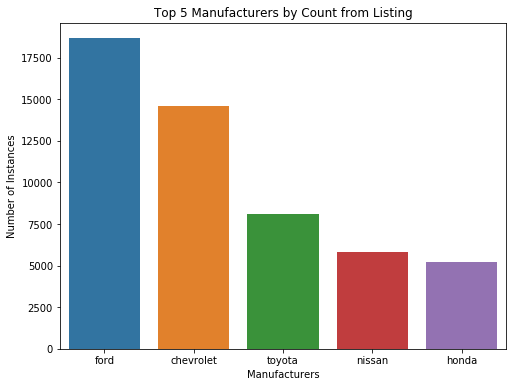

In [5]:
mc = df['manufacturer'].value_counts().head()
plt.figure(figsize = (8, 6))
sns.barplot(x = mc.index, y = mc.values)
plt.title('Top 5 Manufacturers by Count from Listing')
plt.xlabel('Manufacturers')
plt.ylabel('Number of Instances')
plt.show()

#### Before we fit the data using regression models, we would like to standardize the numerical features and one-hot encode the categorical features. For detailed explanations on the methods, please refer to the Portfolio Project 1: Predictive Analysis Structure - Hotel Booking Classification

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
#Build Feature_Selector class
class FeatureSelector(BaseEstimator, TransformerMixin):
    '''
    Select certain features from a Dataframe, return numpy array
    '''
    def __init__(self, columns):
        '''
        columns: list of columns
        '''
        self.columns = columns
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X.loc[:, self.columns].values.reshape(-1, len(self.columns))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         100000 non-null  int64  
 1   year          100000 non-null  float64
 2   manufacturer  100000 non-null  object 
 3   model         100000 non-null  object 
 4   fuel          100000 non-null  object 
 5   odometer      100000 non-null  float64
 6   title_status  100000 non-null  object 
 7   transmission  100000 non-null  object 
 8   state         100000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 6.9+ MB


In [9]:
#StandardScaler and OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#Build Transformer Pipelines
from sklearn.pipeline import make_pipeline, make_union

cat_fs = FeatureSelector(['manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state'])
num_fs = FeatureSelector(['year', 'odometer']) # We treat year column as numeric

cat_trans = make_pipeline(cat_fs, OneHotEncoder(drop = 'first', sparse = False))
num_trans = make_pipeline(num_fs, StandardScaler())

union_trans = make_union(cat_trans, num_trans)

#### We would start from fitting a Random Forest Regression model. Again, all details on reasons behind each individual steps could be found in Portfolio Project 1: Predictive Analysis Structure - Hotel Booking Classification

In [10]:
X = df.drop(['price'], axis = 1)
y = df['price'].values

In [11]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size = 0.1)

In [12]:
#Further split train_all into training and cross validation sets since we do not want to touch the test set yet
X_train, X_cv, y_train, y_cv = train_test_split(X_train_all, y_train_all, test_size = 0.1)

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs = -1)
forest_pipe = make_pipeline(union_trans, forest)

In [14]:
#Now fit the data and make predictions
forest_pipe.fit(X_train, y_train)
pred_cv = forest_pipe.predict(X_cv)

#### Now we can evaluate the model performance, for performance evaluation for regression, we would use the following methods:
1. Residual plot
2. Mean squared error (MSE)
3. R-squared

Text(0.5, 1.0, 'Residual Plot')

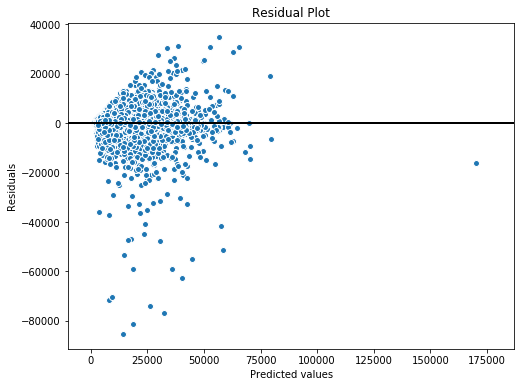

In [15]:
#Residual plot
plt.figure(figsize = (8, 6))
plt.scatter(pred_cv, pred_cv - y_cv, edgecolor = 'white')
plt.hlines(y = 0, xmin = -10000, xmax = pred_cv.max() * 1.1, color = 'black', lw = 2)
plt.xlim(-10000, pred_cv.max() * 1.1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

#### As we can see, our model did not do really well - first, the resuduals are not randomly distributed, which means there are patterns not caught by our model. Second, there are some significant outliers which might have severely impacted the model performance. But before we move on to how we can improve this model, let's quickly check the other performance evaluation metrics.

In [23]:
#MSE
mse = np.mean((y_cv - pred_cv)**2)
print(f'The MSE is {mse}.')

The MSE is 24767472.909284454.


#### However, it is hard to evaluate the mean squared error metric unless we compare with the ones from other models. Thus, we can look at R-squared, which tells us how much of the variation in the response variable the model has captured.

In [25]:
from sklearn.metrics import r2_score
print(f'The R^2 score is {r2_score(y_cv, pred_cv)}')

The R^2 score is 0.8001008691393297


#### Wow, so just based on the R-squared score, our model did not do that bad - we have captured around 80% of the variance of the used car prices.